In [4]:
!conda activate sf


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [215]:
import torch
import torch.nn as nn
from torch import sigmoid
from torch.nn.init import xavier_uniform_, zeros_

def conv(in_planes, out_planes, kernel_size=3):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, padding=(kernel_size-1)//2, stride=2),
        nn.ReLU(inplace=True)
    )


def upconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True)
    )


class PoseExpNet(nn.Module):

    def __init__(self, nb_ref_imgs=2, output_exp=False):
        super(PoseExpNet, self).__init__()
        self.nb_ref_imgs = nb_ref_imgs
        self.output_exp = output_exp
        self.gradients = None
        self.activations = None
        conv_planes = [16, 32, 64, 128, 256, 256, 256]
        self.conv1 = conv(3*(1+self.nb_ref_imgs), conv_planes[0], kernel_size=7)
        self.conv2 = conv(conv_planes[0], conv_planes[1], kernel_size=5)
        self.conv3 = conv(conv_planes[1], conv_planes[2])
        self.conv4 = conv(conv_planes[2], conv_planes[3])
        self.conv5 = conv(conv_planes[3], conv_planes[4])
        self.conv6 = conv(conv_planes[4], conv_planes[5])
        self.conv7 = conv(conv_planes[5], conv_planes[6])

        self.pose_pred = nn.Conv2d(conv_planes[6], 6*self.nb_ref_imgs, kernel_size=1, padding=0)
        
        if self.output_exp:
            upconv_planes = [256, 128, 64, 32, 16]
            self.upconv5 = upconv(conv_planes[4],   upconv_planes[0])
            self.upconv4 = upconv(upconv_planes[0], upconv_planes[1])
            self.upconv3 = upconv(upconv_planes[1], upconv_planes[2])
            self.upconv2 = upconv(upconv_planes[2], upconv_planes[3])
            self.upconv1 = upconv(upconv_planes[3], upconv_planes[4])

            self.predict_mask4 = nn.Conv2d(upconv_planes[1], self.nb_ref_imgs, kernel_size=3, padding=1)
            self.predict_mask3 = nn.Conv2d(upconv_planes[2], self.nb_ref_imgs, kernel_size=3, padding=1)
            self.predict_mask2 = nn.Conv2d(upconv_planes[3], self.nb_ref_imgs, kernel_size=3, padding=1)
            self.predict_mask1 = nn.Conv2d(upconv_planes[4], self.nb_ref_imgs, kernel_size=3, padding=1)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    zeros_(m.bias)
                    
    def activations_hook(self, grad):
#         print('ghudfidfhids')
        self.gradients = grad
#         print(self.gradients)
        
    # method for the gradient extraction
    def get_activations_gradient(self):
#         print(self.gradients)
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        self.activations = x

    def forward(self, target_image, ref_imgs):
        assert(len(ref_imgs) == self.nb_ref_imgs)
        input = [target_image]
        input.extend(ref_imgs)
        input = torch.cat(input, 1)
        out_conv1 = self.conv1(input)
        out_conv2 = self.conv2(out_conv1)
        out_conv3 = self.conv3(out_conv2)
        out_conv4 = self.conv4(out_conv3)
        out_conv5 = self.conv5(out_conv4)
        self.get_activations(out_conv5)
        h = out_conv5.register_hook(self.activations_hook)
        out_conv6 = self.conv6(out_conv5)
        out_conv7 = self.conv7(out_conv6)

        # register the hook
        
        
        pose = self.pose_pred(out_conv7)
        pose = pose.mean(3).mean(2)
        pose = 0.01 * pose.view(pose.size(0), self.nb_ref_imgs, 6)

        if self.output_exp:
            out_upconv5 = self.upconv5(out_conv5  )[:, :, 0:out_conv4.size(2), 0:out_conv4.size(3)]
            out_upconv4 = self.upconv4(out_upconv5)[:, :, 0:out_conv3.size(2), 0:out_conv3.size(3)]
            out_upconv3 = self.upconv3(out_upconv4)[:, :, 0:out_conv2.size(2), 0:out_conv2.size(3)]
            out_upconv2 = self.upconv2(out_upconv3)[:, :, 0:out_conv1.size(2), 0:out_conv1.size(3)]
            out_upconv1 = self.upconv1(out_upconv2)[:, :, 0:input.size(2), 0:input.size(3)]

            exp_mask4 = sigmoid(self.predict_mask4(out_upconv4))
            exp_mask3 = sigmoid(self.predict_mask3(out_upconv3))
            exp_mask2 = sigmoid(self.predict_mask2(out_upconv2))
            exp_mask1 = sigmoid(self.predict_mask1(out_upconv1))
        else:
            exp_mask4 = None
            exp_mask3 = None
            exp_mask2 = None
            exp_mask1 = None

        if self.training:
            return [exp_mask1, exp_mask2, exp_mask3, exp_mask4], pose
        else:
            return exp_mask1, pose

In [216]:
net = PoseExpNet()
#load model here

In [316]:
import argparse
import time
import csv

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import custom_transforms
import models
from utils import tensor2array, save_checkpoint, save_path_formatter, log_output_tensorboard

from loss_functions import photometric_reconstruction_loss, explainability_loss, smooth_loss
from loss_functions import compute_depth_errors, compute_pose_errors
from inverse_warp import pose_vec2mat
from logger import TermLogger, AverageMeter
from tensorboardX import SummaryWriter

parser = argparse.ArgumentParser(description='Structure from Motion Learner training on KITTI and CityScapes Dataset',
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('data', metavar='DIR',
                    help='path to dataset')
parser.add_argument('--dataset-format', default='sequential', metavar='STR',
                    help='dataset format, stacked: stacked frames (from original TensorFlow code) '
                    'sequential: sequential folders (easier to convert to with a non KITTI/Cityscape dataset')
parser.add_argument('--sequence-length', type=int, metavar='N', help='sequence length for training', default=3)
parser.add_argument('--rotation-mode', type=str, choices=['euler', 'quat'], default='euler',
                    help='rotation mode for PoseExpnet : euler (yaw,pitch,roll) or quaternion (last 3 coefficients)')
parser.add_argument('--padding-mode', type=str, choices=['zeros', 'border'], default='zeros',
                    help='padding mode for image warping : this is important for photometric differenciation when going outside target image.'
                         ' zeros will null gradients outside target image.'
                         ' border will only null gradients of the coordinate outside (x or y)')
parser.add_argument('--with-gt', action='store_true', help='use depth ground truth for validation. '
                    'You need to store it in npy 2D arrays see data/kitti_raw_loader.py for an example')
parser.add_argument('--with-pose', action='store_true', help='use pose ground truth for validation. '
                    'You need to store it in text files of 12 columns see data/kitti_raw_loader.py for an example '
                    'Note that for kitti, it is recommend to use odometry train set to test pose')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers')
parser.add_argument('--epochs', default=1, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--epoch-size', default=0, type=int, metavar='N',
                    help='manual epoch size (will match dataset size if not set)')
parser.add_argument('-b', '--batch-size', default=1, type=int,
                    metavar='N', help='mini-batch size')
parser.add_argument('--lr', '--learning-rate', default=2e-4, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum for sgd, alpha parameter for adam')
parser.add_argument('--beta', default=0.999, type=float, metavar='M',
                    help='beta parameters for adam')
parser.add_argument('--weight-decay', '--wd', default=0, type=float,
                    metavar='W', help='weight decay')
parser.add_argument('--print-freq', default=10, type=int,
                    metavar='N', help='print frequency')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--pretrained-disp', dest='pretrained_disp', default=None, metavar='PATH',
                    help='path to pre-trained dispnet model')
parser.add_argument('--pretrained-exppose', dest='pretrained_exp_pose', default=None, metavar='PATH',
                    help='path to pre-trained Exp Pose net model')
parser.add_argument('--seed', default=0, type=int, help='seed for random functions, and network initialization')
parser.add_argument('--log-summary', default='progress_log_summary.csv', metavar='PATH',
                    help='csv where to save per-epoch train and valid stats')
parser.add_argument('--log-full', default='progress_log_full.csv', metavar='PATH',
                    help='csv where to save per-gradient descent train stats')
parser.add_argument('-p', '--photo-loss-weight', type=float, help='weight for photometric loss', metavar='W', default=1)
parser.add_argument('-m', '--mask-loss-weight', type=float, help='weight for explainabilty mask loss', metavar='W', default=0)
parser.add_argument('-s', '--smooth-loss-weight', type=float, help='weight for disparity smoothness loss', metavar='W', default=0.1)
parser.add_argument('--log-output', action='store_true', help='will log dispnet outputs and warped imgs at validation step')
parser.add_argument('-f', '--training-output-freq', type=int,
                    help='frequence for outputting dispnet outputs and warped imgs at training for all scales. '
                         'if 0, will not output',
                    metavar='N', default=0)

best_error = -1
n_iter = 0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def main():
    global best_error, n_iter, device
    args = parser.parse_args('./dataset/formatted/data/ --pretrained-disp trained_models/dispnet_model_best.pth.tar --pretrained-exppose trained_models/exp_pose_model_best.pth.tar -m0.2 -s0.1 --epoch-size 1000 --sequence-length 5 --log-output --with-gt'.split())
    if args.dataset_format == 'stacked':
        from datasets.stacked_sequence_folders import SequenceFolder
    elif args.dataset_format == 'sequential':
        from datasets.sequence_folders import SequenceFolder
    save_path = save_path_formatter(args, parser)
    args.save_path = 'checkpoints'/save_path
    print('=> will save everything to {}'.format(args.save_path))
    args.save_path.makedirs_p()
    torch.manual_seed(args.seed)
    if args.evaluate:
        args.epochs = 0

    tb_writer = SummaryWriter(args.save_path)
    # Data loading code
    normalize = custom_transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                            std=[0.5, 0.5, 0.5])
    train_transform = custom_transforms.Compose([
        custom_transforms.RandomHorizontalFlip(),
        custom_transforms.RandomScaleCrop(),
        custom_transforms.ArrayToTensor(),
        normalize
    ])

    valid_transform = custom_transforms.Compose([custom_transforms.ArrayToTensor(), normalize])

    print("=> fetching scenes in '{}'".format(args.data))
    train_set = SequenceFolder(
        args.data,
        transform=train_transform,
        seed=args.seed,
        train=True,
        sequence_length=args.sequence_length
    )

    # if no Groundtruth is avalaible, Validation set is the same type as training set to measure photometric loss from warping
    if args.with_gt:
        if args.with_pose:
            from datasets.validation_folders import ValidationSetWithPose
            val_set = ValidationSetWithPose(
                args.data,
                sequence_length=args.sequence_length,
                transform=valid_transform)
        else:
            from datasets.validation_folders import ValidationSet
            val_set = ValidationSet(
                args.data,
                transform=valid_transform
            )
    else:
        val_set = SequenceFolder(
            args.data,
            transform=valid_transform,
            seed=args.seed,
            train=False,
            sequence_length=args.sequence_length,
        )
    print('{} samples found in {} train scenes'.format(len(train_set), len(train_set.scenes)))
    print('{} samples found in {} valid scenes'.format(len(val_set), len(val_set.scenes)))
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

    if args.epoch_size == 0:
        args.epoch_size = len(train_loader)

    # create model
    print("=> creating model")

    disp_net = models.DispNetS().to(device)
    output_exp = args.mask_loss_weight > 0
    if not output_exp:
        print("=> no mask loss, PoseExpnet will only output pose")
 
    pose_exp_net = PoseExpNet(nb_ref_imgs=args.sequence_length - 1, output_exp=args.mask_loss_weight > 0).to(device)
    print(type(pose_exp_net))
    if args.pretrained_exp_pose:
        print("=> using pre-trained weights for explainabilty and pose net")
        weights = torch.load(args.pretrained_exp_pose)
        pose_exp_net.load_state_dict(weights['state_dict'], strict=False)
    else:
        pose_exp_net.init_weights()

    if args.pretrained_disp:
        print("=> using pre-trained weights for Dispnet")
        weights = torch.load(args.pretrained_disp)
        disp_net.load_state_dict(weights['state_dict'])
    else:
        disp_net.init_weights()

    cudnn.benchmark = True
#     disp_net = torch.nn.DataParallel(disp_net)
#     pose_exp_net = torch.nn.DataParallel(pose_exp_net)

    print('=> setting adam solver')

    optim_params = [
        {'params': disp_net.parameters(), 'lr': args.lr},
        {'params': pose_exp_net.parameters(), 'lr': args.lr}
    ]
    optimizer = torch.optim.Adam(optim_params,
                                 betas=(args.momentum, args.beta),
                                 weight_decay=args.weight_decay)

    with open(args.save_path/args.log_summary, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(['train_loss', 'validation_loss'])

    with open(args.save_path/args.log_full, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t')
        writer.writerow(['train_loss', 'photo_loss', 'explainability_loss', 'smooth_loss'])

    logger = TermLogger(n_epochs=args.epochs, train_size=min(len(train_loader), args.epoch_size), valid_size=len(val_loader))
    logger.epoch_bar.start()

#     if args.pretrained_disp or args.evaluate:
#         logger.reset_valid_bar()
#         if args.with_gt and args.with_pose:
#             errors, error_names = validate_with_gt_pose(args, val_loader, disp_net, pose_exp_net, 0, logger, tb_writer)
#         elif args.with_gt:
#             errors, error_names = validate_with_gt(args, val_loader, disp_net, 0, logger, tb_writer)
#         else:
#             errors, error_names = validate_without_gt(args, val_loader, disp_net, pose_exp_net, 0, logger, tb_writer)
#         for error, name in zip(errors, error_names):
#             tb_writer.add_scalar(name, error, 0)
#         error_string = ', '.join('{} : {:.3f}'.format(name, error) for name, error in zip(error_names[2:9], errors[2:9]))
#         logger.valid_writer.write(' * Avg {}'.format(error_string))

    for epoch in range(args.epochs):
        logger.epoch_bar.update(epoch)

        # train for one epoch
        logger.reset_train_bar()
        train_loss, image_inputs = train(args, train_loader, disp_net, pose_exp_net, optimizer, args.epoch_size, logger, tb_writer)
        logger.train_writer.write(' * Avg Loss : {:.3f}'.format(train_loss))

        # evaluate on validation set
#         logger.reset_valid_bar()
#         if args.with_gt and args.with_pose:
#             errors, error_names = validate_with_gt_pose(args, val_loader, disp_net, pose_exp_net, epoch, logger, tb_writer)
#         elif args.with_gt:
#             errors, error_names = validate_with_gt(args, val_loader, disp_net, epoch, logger, tb_writer)
#         else:
#             errors, error_names = validate_without_gt(args, val_loader, disp_net, pose_exp_net, epoch, logger, tb_writer)
#         error_string = ', '.join('{} : {:.3f}'.format(name, error) for name, error in zip(error_names, errors))
#         logger.valid_writer.write(' * Avg {}'.format(error_string))

#         for error, name in zip(errors, error_names):
#             tb_writer.add_scalar(name, error, epoch)

        # Up to you to chose the most relevant error to measure your model's performance, careful some measures are to maximize (such as a1,a2,a3)
#         decisive_error = errors[1]
#         if best_error < 0:
#             best_error = decisive_error

#         # remember lowest error and save checkpoint
#         is_best = decisive_error < best_error
#         best_error = min(best_error, decisive_error)
#         save_checkpoint(
#             args.save_path, {
#                 'epoch': epoch + 1,
#                 'state_dict': disp_net.module.state_dict()
#             }, {
#                 'epoch': epoch + 1,
#                 'state_dict': pose_exp_net.module.state_dict()
#             },
#             is_best)

#         with open(args.save_path/args.log_summary, 'a') as csvfile:
#             writer = csv.writer(csvfile, delimiter='\t')
#             writer.writerow([train_loss, decisive_error])
    logger.epoch_bar.finish()
    return pose_exp_net.get_activations_gradient(), pose_exp_net.activations, image_inputs


def train(args, train_loader, disp_net, pose_exp_net, optimizer, epoch_size, logger, tb_writer):
    global n_iter, device
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter(precision=4)
    w1, w2, w3 = args.photo_loss_weight, args.mask_loss_weight, args.smooth_loss_weight

    # switch to train mode
    disp_net.train()
    pose_exp_net.train()

    end = time.time()
    logger.train_bar.update(0)
    image_inputs = 0
    for i, (tgt_img, ref_imgs, intrinsics, intrinsics_inv) in enumerate(train_loader):
        if (i==7):
            break
        image_inputs = (tgt_img, ref_imgs)
        log_losses = i > 0 and n_iter % args.print_freq == 0
        log_output = args.training_output_freq > 0 and n_iter % args.training_output_freq == 0

        # measure data loading time
        data_time.update(time.time() - end)
        tgt_img = tgt_img.to(device)
        ref_imgs = [img.to(device) for img in ref_imgs]
        intrinsics = intrinsics.to(device)

        # compute output
        disparities = disp_net(tgt_img)
        depth = [1/disp for disp in disparities]
        explainability_mask, pose = pose_exp_net(tgt_img, ref_imgs)

        loss_1, warped, diff = photometric_reconstruction_loss(tgt_img, ref_imgs, intrinsics,
                                                               depth, explainability_mask, pose,
                                                               args.rotation_mode, args.padding_mode)
        if w2 > 0:
            loss_2 = explainability_loss(explainability_mask)
        else:
            loss_2 = 0
        loss_3 = smooth_loss(depth)

        loss = w1*loss_1 + w2*loss_2 + w3*loss_3

        if log_losses:
            tb_writer.add_scalar('photometric_error', loss_1.item(), n_iter)
            if w2 > 0:
                tb_writer.add_scalar('explanability_loss', loss_2.item(), n_iter)
            tb_writer.add_scalar('disparity_smoothness_loss', loss_3.item(), n_iter)
            tb_writer.add_scalar('total_loss', loss.item(), n_iter)

        if log_output:
            tb_writer.add_image('train Input', tensor2array(tgt_img[0]), n_iter)
            for k, scaled_maps in enumerate(zip(depth, disparities, warped, diff, explainability_mask)):
                log_output_tensorboard(tb_writer, "train", 0, " {}".format(k), n_iter, *scaled_maps)

        # record loss and EPE
        losses.update(loss.item(), args.batch_size)

        # compute gradient and do Adam step
        optimizer.zero_grad()
        (-1*loss).backward()
#         optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        with open(args.save_path/args.log_full, 'a') as csvfile:
            writer = csv.writer(csvfile, delimiter='\t')
            writer.writerow([loss.item(), loss_1.item(), loss_2.item() if w2 > 0 else 0, loss_3.item()])
        logger.train_bar.update(i+1)
        if i % args.print_freq == 0:
            logger.train_writer.write('Train: Time {} Data {} Loss {}'.format(batch_time, data_time, losses))
        if i >= epoch_size - 1:
            break

        n_iter += 1

    return losses.avg[0], image_inputs


@torch.no_grad()
def validate_without_gt(args, val_loader, disp_net, pose_exp_net, epoch, logger, tb_writer, sample_nb_to_log=3):
    global device
    batch_time = AverageMeter()
    losses = AverageMeter(i=3, precision=4)
    log_outputs = sample_nb_to_log > 0
    # Output the logs throughout the whole dataset
    batches_to_log = list(np.linspace(0, len(val_loader), sample_nb_to_log).astype(int))
    w1, w2, w3 = args.photo_loss_weight, args.mask_loss_weight, args.smooth_loss_weight
    poses = np.zeros(((len(val_loader)-1) * args.batch_size * (args.sequence_length-1), 6))
    disp_values = np.zeros(((len(val_loader)-1) * args.batch_size * 3))

    # switch to evaluate mode
    disp_net.eval()
    pose_exp_net.eval()

    end = time.time()
    logger.valid_bar.update(0)
    for i, (tgt_img, ref_imgs, intrinsics, intrinsics_inv) in enumerate(val_loader):
        tgt_img = tgt_img.to(device)
        ref_imgs = [img.to(device) for img in ref_imgs]
        intrinsics = intrinsics.to(device)
        intrinsics_inv = intrinsics_inv.to(device)

        # compute output
        disp = disp_net(tgt_img)
        depth = 1/disp
        explainability_mask, pose = pose_exp_net(tgt_img, ref_imgs)

        loss_1, warped, diff = photometric_reconstruction_loss(tgt_img, ref_imgs,
                                                               intrinsics, depth,
                                                               explainability_mask, pose,
                                                               args.rotation_mode, args.padding_mode)
        loss_1 = loss_1.item()
        if w2 > 0:
            loss_2 = explainability_loss(explainability_mask).item()
        else:
            loss_2 = 0
        loss_3 = smooth_loss(depth).item()

        if log_outputs and i in batches_to_log:  # log first output of wanted batches
            index = batches_to_log.index(i)
            if epoch == 0:
                for j, ref in enumerate(ref_imgs):
                    tb_writer.add_image('val Input {}/{}'.format(j, index), tensor2array(tgt_img[0]), 0)
                    tb_writer.add_image('val Input {}/{}'.format(j, index), tensor2array(ref[0]), 1)

            log_output_tensorboard(tb_writer, 'val', index, '', epoch, 1./disp, disp, warped[0], diff[0], explainability_mask)

        if log_outputs and i < len(val_loader)-1:
            step = args.batch_size*(args.sequence_length-1)
            poses[i * step:(i+1) * step] = pose.cpu().view(-1, 6).numpy()
            step = args.batch_size * 3
            disp_unraveled = disp.cpu().view(args.batch_size, -1)
            disp_values[i * step:(i+1) * step] = torch.cat([disp_unraveled.min(-1)[0],
                                                            disp_unraveled.median(-1)[0],
                                                            disp_unraveled.max(-1)[0]]).numpy()

        loss = w1*loss_1 + w2*loss_2 + w3*loss_3
        losses.update([loss, loss_1, loss_2])

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        logger.valid_bar.update(i+1)
        if i % args.print_freq == 0:
            logger.valid_writer.write('valid: Time {} Loss {}'.format(batch_time, losses))
    if log_outputs:
        prefix = 'valid poses'
        coeffs_names = ['tx', 'ty', 'tz']
        if args.rotation_mode == 'euler':
            coeffs_names.extend(['rx', 'ry', 'rz'])
        elif args.rotation_mode == 'quat':
            coeffs_names.extend(['qx', 'qy', 'qz'])
        for i in range(poses.shape[1]):
            tb_writer.add_histogram('{} {}'.format(prefix, coeffs_names[i]), poses[:, i], epoch)
        tb_writer.add_histogram('disp_values', disp_values, epoch)
    logger.valid_bar.update(len(val_loader))
    return losses.avg, ['Validation Total loss', 'Validation Photo loss', 'Validation Exp loss']


@torch.no_grad()
def validate_with_gt_pose(args, val_loader, disp_net, pose_exp_net, epoch, logger, tb_writer, sample_nb_to_log=3):
    global device
    batch_time = AverageMeter()
    depth_error_names = ['abs_diff', 'abs_rel', 'sq_rel', 'a1', 'a2', 'a3']
    depth_errors = AverageMeter(i=len(depth_error_names), precision=4)
    pose_error_names = ['ATE', 'RTE']
    pose_errors = AverageMeter(i=2, precision=4)
    log_outputs = sample_nb_to_log > 0
    # Output the logs throughout the whole dataset
    batches_to_log = list(np.linspace(0, len(val_loader), sample_nb_to_log).astype(int))
    poses_values = np.zeros(((len(val_loader)-1) * args.batch_size * (args.sequence_length-1), 6))
    disp_values = np.zeros(((len(val_loader)-1) * args.batch_size * 3))

    # switch to evaluate mode
    disp_net.eval()
    pose_exp_net.eval()

    end = time.time()
    logger.valid_bar.update(0)
    for i, (tgt_img, ref_imgs, gt_depth, gt_poses) in enumerate(val_loader):
        tgt_img = tgt_img.to(device)
        gt_depth = gt_depth.to(device)
        gt_poses = gt_poses.to(device)
        ref_imgs = [img.to(device) for img in ref_imgs]
        b = tgt_img.shape[0]

        # compute output
        output_disp = disp_net(tgt_img)
        output_depth = 1/output_disp
        explainability_mask, output_poses = pose_exp_net(tgt_img, ref_imgs)

        reordered_output_poses = torch.cat([output_poses[:, :gt_poses.shape[1]//2],
                                            torch.zeros(b, 1, 6).to(output_poses),
                                            output_poses[:, gt_poses.shape[1]//2:]], dim=1)

        # pose_vec2mat only takes B, 6 tensors, so we simulate a batch dimension of B * seq_length
        unravelled_poses = reordered_output_poses.reshape(-1, 6)
        unravelled_matrices = pose_vec2mat(unravelled_poses, rotation_mode=args.rotation_mode)
        inv_transform_matrices = unravelled_matrices.reshape(b, -1, 3, 4)

        rot_matrices = inv_transform_matrices[..., :3].transpose(-2, -1)
        tr_vectors = -rot_matrices @ inv_transform_matrices[..., -1:]

        transform_matrices = torch.cat([rot_matrices, tr_vectors], axis=-1)

        first_inv_transform = inv_transform_matrices.reshape(b, -1, 3, 4)[:, :1]
        final_poses = first_inv_transform[..., :3] @ transform_matrices
        final_poses[..., -1:] += first_inv_transform[..., -1:]
        final_poses = final_poses.reshape(b, -1, 3, 4)

        if log_outputs and i in batches_to_log:  # log first output of wanted batches
            index = batches_to_log.index(i)
            if epoch == 0:
                for j, ref in enumerate(ref_imgs):
                    tb_writer.add_image('val Input {}/{}'.format(j, index), tensor2array(tgt_img[0]), 0)
                    tb_writer.add_image('val Input {}/{}'.format(j, index), tensor2array(ref[0]), 1)

            log_output_tensorboard(tb_writer, 'val', index, '', epoch, output_depth, output_disp, None, None, explainability_mask)

        if log_outputs and i < len(val_loader)-1:
            step = args.batch_size*(args.sequence_length-1)
            poses_values[i * step:(i+1) * step] = output_poses.cpu().view(-1, 6).numpy()
            step = args.batch_size * 3
            disp_unraveled = output_disp.cpu().view(args.batch_size, -1)
            disp_values[i * step:(i+1) * step] = torch.cat([disp_unraveled.min(-1)[0],
                                                            disp_unraveled.median(-1)[0],
                                                            disp_unraveled.max(-1)[0]]).numpy()

        depth_errors.update(compute_depth_errors(gt_depth, output_depth[:, 0]))
        pose_errors.update(compute_pose_errors(gt_poses, final_poses))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        logger.valid_bar.update(i+1)
        if i % args.print_freq == 0:
            logger.valid_writer.write(
                'valid: Time {} Abs Error {:.4f} ({:.4f}), ATE {:.4f} ({:.4f})'.format(batch_time,
                                                                                       depth_errors.val[0],
                                                                                       depth_errors.avg[0],
                                                                                       pose_errors.val[0],
                                                                                       pose_errors.avg[0]))
    if log_outputs:
        prefix = 'valid poses'
        coeffs_names = ['tx', 'ty', 'tz']
        if args.rotation_mode == 'euler':
            coeffs_names.extend(['rx', 'ry', 'rz'])
        elif args.rotation_mode == 'quat':
            coeffs_names.extend(['qx', 'qy', 'qz'])
        for i in range(poses_values.shape[1]):
            tb_writer.add_histogram('{} {}'.format(prefix, coeffs_names[i]), poses_values[:, i], epoch)
        tb_writer.add_histogram('disp_values', disp_values, epoch)
    logger.valid_bar.update(len(val_loader))
    return depth_errors.avg + pose_errors.avg, depth_error_names + pose_error_names


@torch.no_grad()
def validate_with_gt(args, val_loader, disp_net, epoch, logger, tb_writer, sample_nb_to_log=3):
    global device
    batch_time = AverageMeter()
    error_names = ['abs_diff', 'abs_rel', 'sq_rel', 'a1', 'a2', 'a3']
    errors = AverageMeter(i=len(error_names))
    log_outputs = sample_nb_to_log > 0
    # Output the logs throughout the whole dataset
    batches_to_log = list(np.linspace(0, len(val_loader)-1, sample_nb_to_log).astype(int))

    # switch to evaluate mode
    disp_net.eval()

    end = time.time()
    logger.valid_bar.update(0)
    for i, (tgt_img, depth) in enumerate(val_loader):
        tgt_img = tgt_img.to(device)
        depth = depth.to(device)

        # compute output
        output_disp = disp_net(tgt_img)
        output_depth = 1/output_disp[:, 0]

        if log_outputs and i in batches_to_log:
            index = batches_to_log.index(i)
            if epoch == 0:
                tb_writer.add_image('val Input/{}'.format(index), tensor2array(tgt_img[0]), 0)
                depth_to_show = depth[0]
                tb_writer.add_image('val target Depth Normalized/{}'.format(index),
                                    tensor2array(depth_to_show, max_value=None),
                                    epoch)
                depth_to_show[depth_to_show == 0] = 1000
                disp_to_show = (1/depth_to_show).clamp(0, 10)
                tb_writer.add_image('val target Disparity Normalized/{}'.format(index),
                                    tensor2array(disp_to_show, max_value=None, colormap='magma'),
                                    epoch)

            tb_writer.add_image('val Dispnet Output Normalized/{}'.format(index),
                                tensor2array(output_disp[0], max_value=None, colormap='magma'),
                                epoch)
            tb_writer.add_image('val Depth Output Normalized/{}'.format(index),
                                tensor2array(output_depth[0], max_value=None),
                                epoch)
        errors.update(compute_depth_errors(depth, output_depth))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        logger.valid_bar.update(i+1)
        if i % args.print_freq == 0:
            logger.valid_writer.write('valid: Time {} Abs Error {:.4f} ({:.4f})'.format(batch_time, errors.val[0], errors.avg[0]))
    logger.valid_bar.update(len(val_loader))
    return errors.avg, error_names

In [317]:
grad, act, image_inputs = main()

=> will save everything to checkpoints/data,epoch_size1000,seq5,m0.2/02-04-02:56
=> fetching scenes in './dataset/formatted/data/'
3174 samples found in 2 train scenes
0 samples found in 0 valid scenes
=> creating model
<class '__main__.PoseExpNet'>
=> using pre-trained weights for explainabilty and pose net
=> using pre-trained weights for Dispnet
=> setting adam solver










N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:07:54
Train: Time 0.474 (0.474) Data 0.356 (0.356) Loss 2.3834 (2.3834)
  0% (2 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:49
  0% (3 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:46
  0% (4 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:03:15
  0% (5 of 1000) |                       | Elapsed Time: 0:00:00 ETA: 

In [241]:
act.shape

torch.Size([1, 256, 4, 13])

In [242]:
weights = grad.mean(3).mean(2)

In [113]:
weights = weights.unsqueeze(2).unsqueeze(3)

In [114]:
weights.shape

torch.Size([1, 256, 1, 1])

In [115]:
w_act = act*weights[:]

In [116]:
w_act.shape

torch.Size([1, 256, 4, 13])

In [161]:
a = torch.zeros(1).cuda()
ref_w_act1 = torch.maximum(a,w_act[:,0:64,:,:].mean(1,keepdim=True))
ref_w_act2 = torch.maximum(a,w_act[:,64:128,:,:].mean(1,keepdim=True))
ref_w_act3 = torch.maximum(a,w_act[:,128:192,:,:].mean(1,keepdim=True))
ref_w_act4 = torch.maximum(a,w_act[:,192:256,:,:].mean(1,keepdim=True))

In [162]:
ref_w_act_interp = [0]*4
import torch.nn.functional as F
ref_w_act_interp[0] = F.interpolate(ref_w_act1, size=(128, 416), mode='bilinear', align_corners=False)
ref_w_act_interp[1] = F.interpolate(ref_w_act2, size=(128, 416), mode='bilinear', align_corners=False)
ref_w_act_interp[2] = F.interpolate(ref_w_act3, size=(128, 416), mode='bilinear', align_corners=False)
ref_w_act_interp[3] = F.interpolate(ref_w_act4, size=(128, 416), mode='bilinear', align_corners=False)
heatmap_torch = torch.stack(ref_w_act_interp , dim=0).squeeze(1).squeeze(1)

In [170]:
heatmap = heatmap_torch.detach().cpu().numpy()/heatmap_torch.max().detach().cpu().numpy()

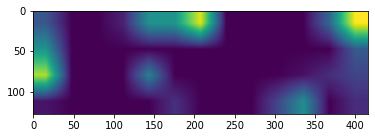

In [171]:
import matplotlib.pyplot as plt
# plt.imshow(ref_w_act1_interp.squeeze().detach().cpu().numpy())
plt.imshow(heatmap[0])

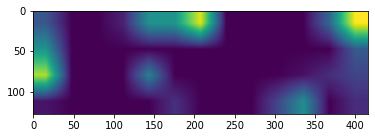

In [172]:
import cv2
ref_w_act1_interp = cv2.resize(ref_w_act1.squeeze().detach().cpu().numpy(), (416, 128))
plt.imshow(ref_w_act1_interp)

In [173]:
heatmap.max()

1.0

In [174]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

In [178]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

In [179]:
import cv2
import matplotlib
# from torchvision.transforms.functional import to_pil_image
imgs = image_inputs[1]
%matplotlib inline
plt.figure(figsize=(10,10))
x = 0.004
# for ii,img in enumerate(imgs[8::2]):
count = 0
for ii in range(4):
    count+=1
    img_ = np.array(denormalize(imgs[ii].cpu(), mean, std))
#     plt.subplot(2,2,ii+1)
    plt.subplot(2,2,count)
    heatmap_ = cv2.resize(heatmap[ii], (img_.shape[1], img_.shape[0]))
    heatmap_ = np.uint8(255 * (1-heatmap_))
    heatmap_ = cv2.applyColorMap(heatmap_, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap_ * 0.8 + img_
    superimposed_img = superimposed_img/np.max(superimposed_img)
#     cv2.imwrite('./map.jpg', superimposed_img)
    plt.axis('off')
    plt.imshow(superimposed_img)
    plt.title(idx_to_label_dict[label.item()])
#     plt.colorbar()
plt.savefig('./ADL_results/with_attention_2_.png')

IndexError: index 1 is out of bounds for dimension 0 with size 1

<Figure size 720x720 with 0 Axes>

In [180]:
imgs.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
grad, act, image_inputs 

In [318]:
weights = grad.mean(3).mean(2).unsqueeze(2).unsqueeze(3)
w_act = act*weights

In [319]:
a = torch.zeros(1).cuda()
out = torch.maximum(a,w_act.mean(1,keepdim=True))
interp_out = F.interpolate(out, size=(128, 416), mode='bilinear', align_corners=False)

In [320]:
heatmap = (interp_out.detach().cpu().numpy()/interp_out.max().detach().cpu().numpy()).squeeze(0).squeeze(0)

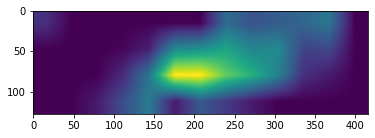

In [321]:
import matplotlib.pyplot as plt
# plt.imshow(ref_w_act1_interp.squeeze().detach().cpu().numpy())
plt.imshow(heatmap)

In [322]:
img = image_inputs[0][0]

In [323]:
img.shape

torch.Size([3, 128, 416])

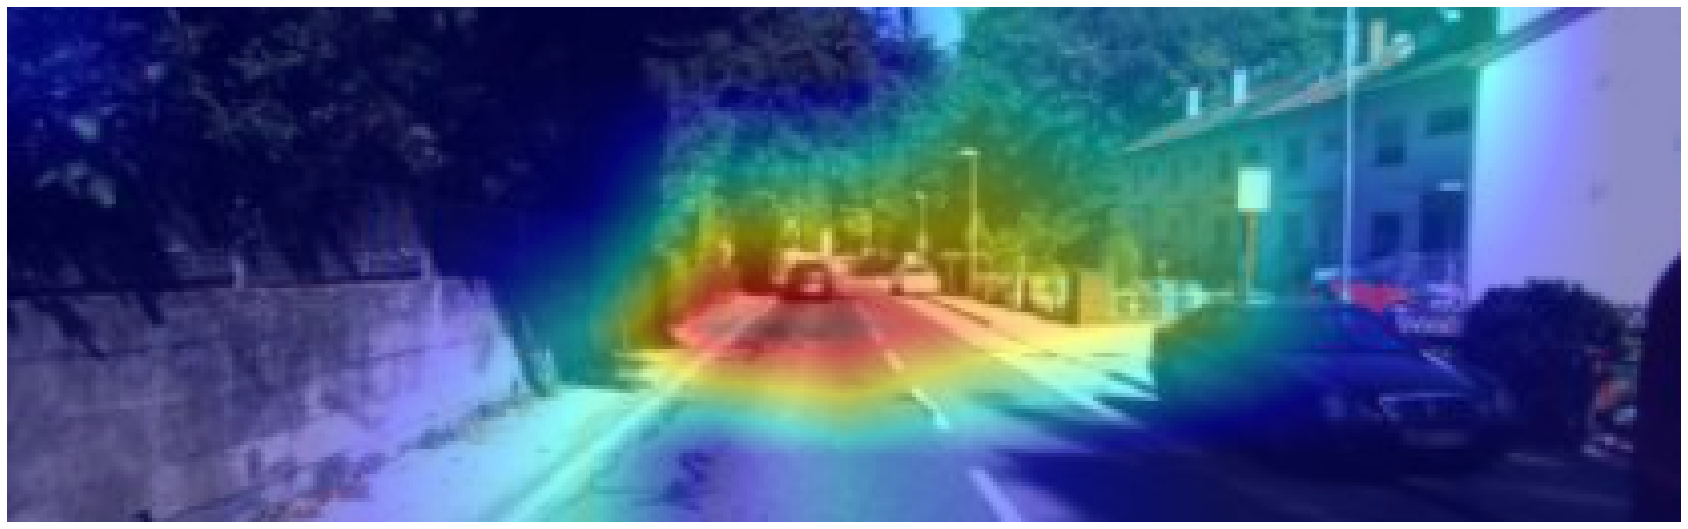

In [324]:
import cv2
import matplotlib
from torchvision.transforms.functional import to_pil_image

imgs = image_inputs[0]
%matplotlib inline
plt.figure(figsize=(30,10))
x = 0.004
# for ii,img in enumerate(imgs[8::2]):
count = 0
for ii in range(1):
    count+=1
    img_ = np.array(denormalize(imgs[ii].cpu(), mean, std))
#     plt.subplot(2,2,ii+1)
    plt.subplot(1,1,count)
    heatmap_ = cv2.resize(heatmap, (img_.shape[1], img_.shape[0]))
    heatmap_ = np.uint8(255 * (1-heatmap_))
    heatmap_ = cv2.applyColorMap(heatmap_, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap_ * 0.8 + img_
    superimposed_img = superimposed_img/np.max(superimposed_img)
#     cv2.imwrite('./map.jpg', superimposed_img)
    plt.axis('off')
    plt.imshow(superimposed_img)
#     plt.title(idx_to_label_dict[label.item()])
#     plt.colorbar()
plt.savefig('./map.png')

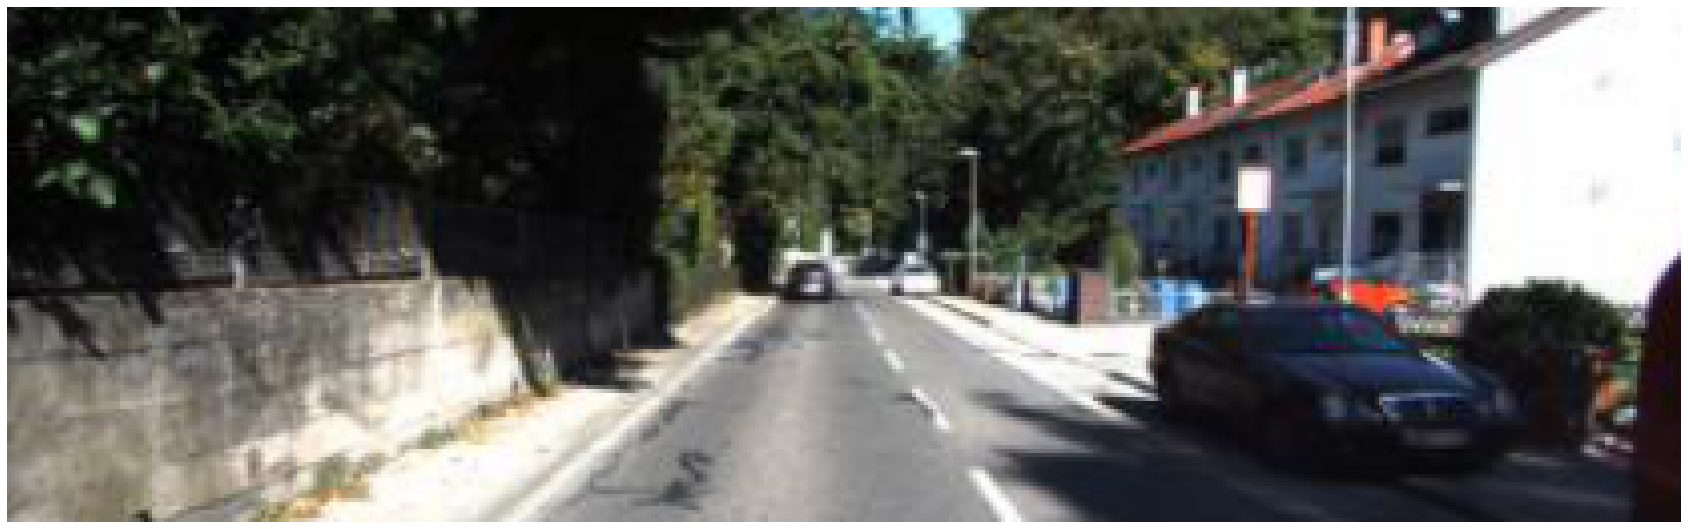

In [325]:
plt.figure(figsize=(30,10))
plt.imshow(img_)
plt.axis('off')
plt.savefig('./original.png')